In [3]:
# sales_forecast_from_excel.py

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import json

warnings.filterwarnings("ignore", category=FutureWarning)

# Try Prophet first, fallback Holt-Winters
try:
    from prophet import Prophet
    use_prophet = True
except ImportError:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    use_prophet = False


def preprocess(df):
    """Preprocess sales data: fill missing months & values per product."""
    processed = []

    for prod, g in df.groupby("product_code"):
        g = g.set_index("date").asfreq("MS")  # ensure monthly frequency
        # Fill missing values
        if g["sales"].isna().sum() > 0:
            month_medians = g.groupby(g.index.month)["sales"].transform("median")
            g["sales"] = g["sales"].fillna(month_medians)
            g["sales"] = g["sales"].interpolate().ffill().bfill()
        g["product_code"] = prod
        g = g.reset_index()
        processed.append(g)

    return pd.concat(processed)


def train_forecast(df, horizon=3):
    """Train Prophet/HoltWinters, forecast horizon months, evaluate on last 6 months."""
    forecasts_by_date = []
    metrics = []

    for prod, g in df.groupby("product_code"):
        g = g.sort_values("date")
        train, test = g.iloc[:-6], g.iloc[-6:]

        # Train model
        if use_prophet:
            model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            model.fit(train.rename(columns={"date": "ds", "sales": "y"}))
            future = model.make_future_dataframe(periods=horizon + len(test), freq="MS")
            fc = model.predict(future)[["ds", "yhat"]].set_index("ds").tail(len(test) + horizon)
            fc = fc.rename(columns={"yhat": "forecast"})
        else:
            model = ExponentialSmoothing(train["sales"], seasonal="add", seasonal_periods=12)
            model = model.fit()
            fc_vals = model.forecast(len(test) + horizon)
            fc = pd.DataFrame({
                "ds": pd.date_range(train["date"].iloc[-1], periods=len(test) + horizon + 1, freq="MS")[1:],
                "forecast": fc_vals
            }).set_index("ds")

        # MAPE on test
        y_true = test.set_index("date")["sales"].values
        y_pred = fc.iloc[:len(test)]["forecast"].values
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        acc = 100 - mape
        metrics.append({"product_code": prod, "mape": round(mape, 2), "accuracy": round(acc, 2)})

        # Future 3 months → round to integers
        fc_future = fc.iloc[len(test):len(test)+horizon]
        for d, val in fc_future["forecast"].items():
            d_str = str(d.date())
            # If date already exists in dict, append product value
            if any(d_str in f for f in forecasts_by_date):
                for f in forecasts_by_date:
                    if d_str in f:
                        f[d_str][prod] = int(round(val))
            else:
                forecasts_by_date.append({d_str: {prod: int(round(val))}})

        # Plot chart
        plt.figure(figsize=(8, 4))
        plt.plot(g["date"], g["sales"], label="Actual", color="blue")
        plt.plot(fc.index, fc["forecast"], label="Forecast", color="red")
        plt.axvline(test["date"].iloc[0], color="gray", linestyle="--", label="Train/Test Split")
        plt.title(f"Product {prod} Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"forecasted_products": forecasts_by_date, "metrics": metrics}


def main():
    input_file = "inventory_sales.xlsx"   # <-- Excel file

    # Load Excel
    raw = pd.read_excel(input_file, parse_dates=["date"])
    print("✅ Data loaded:", raw.shape)

    # Preprocess
    processed = preprocess(raw)

    # Plot preprocessing
    plt.figure(figsize=(8, 4))
    for prod, g in processed.groupby("product_code"):
        plt.plot(g["date"], g["sales"], label=prod)
    plt.title("Preprocessed Sales Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Forecast
    result = train_forecast(processed, horizon=3)

    # Output JSON
    print(json.dumps(result, indent=4))


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'statsmodels'

Importing plotly failed. Interactive plots will not work.


✅ Data loaded: (600, 10)


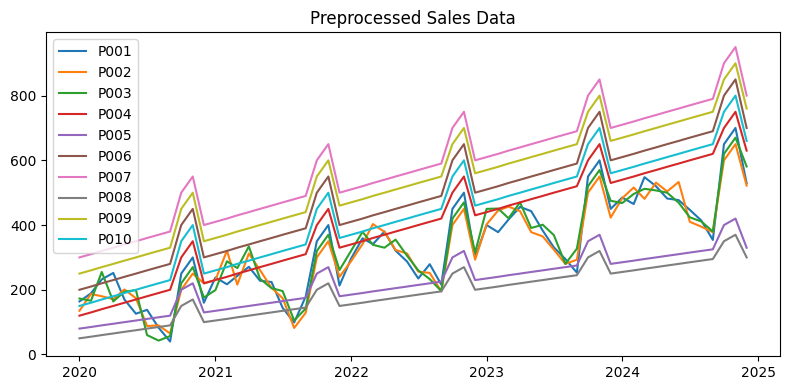

23:27:02 - cmdstanpy - INFO - Chain [1] start processing
23:27:02 - cmdstanpy - INFO - Chain [1] done processing


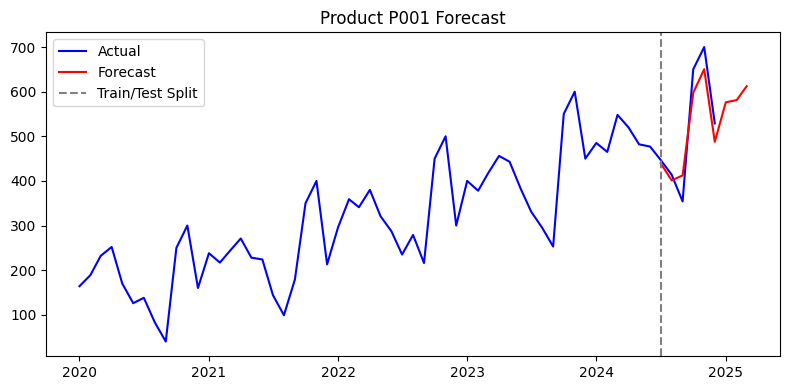

23:27:03 - cmdstanpy - INFO - Chain [1] start processing
23:27:03 - cmdstanpy - INFO - Chain [1] done processing


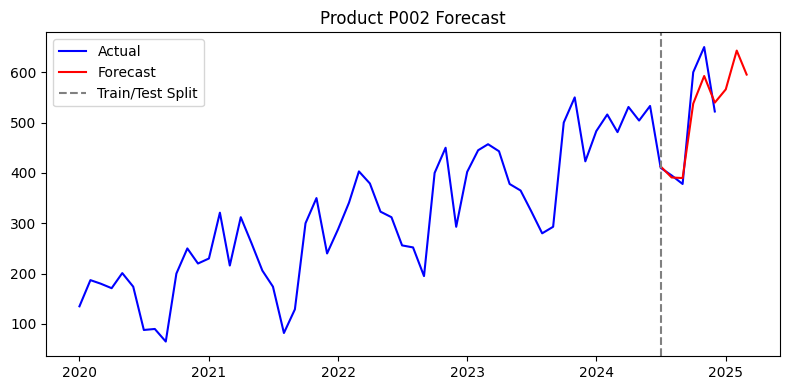

23:27:03 - cmdstanpy - INFO - Chain [1] start processing
23:27:03 - cmdstanpy - INFO - Chain [1] done processing


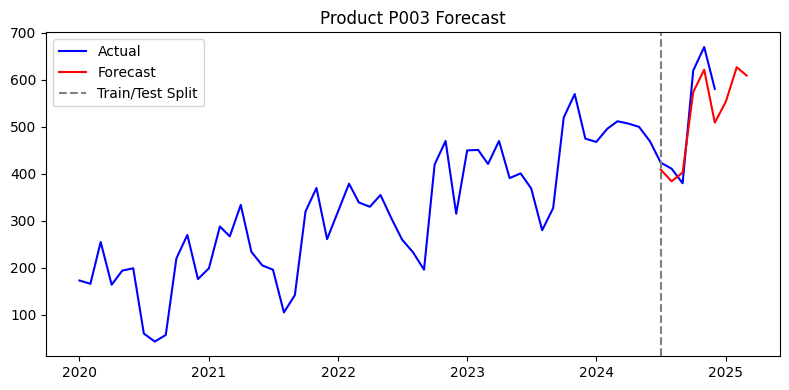

23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing


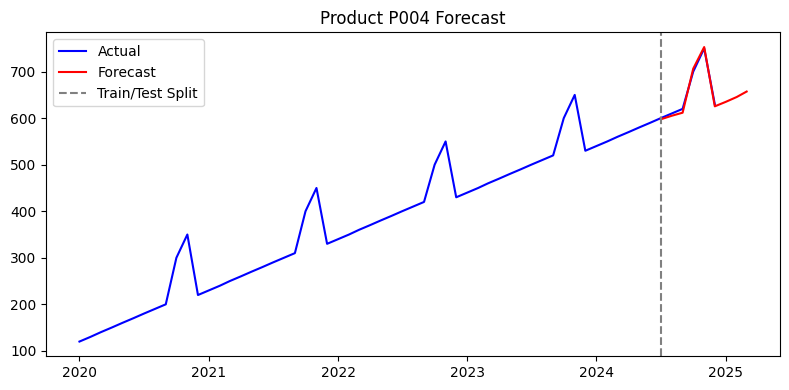

23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:05 - cmdstanpy - INFO - Chain [1] done processing


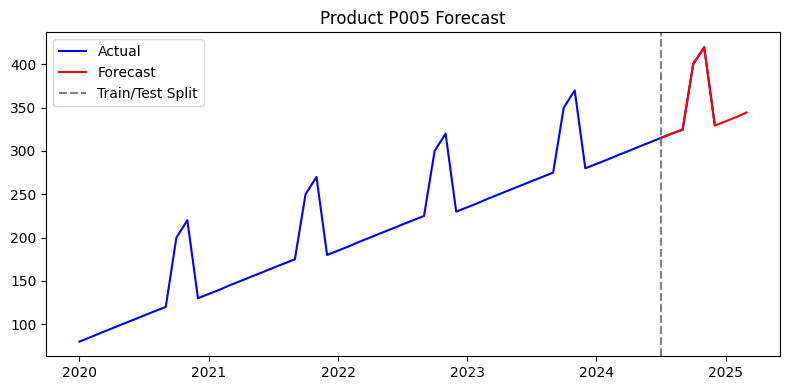

23:27:05 - cmdstanpy - INFO - Chain [1] start processing
23:27:05 - cmdstanpy - INFO - Chain [1] done processing


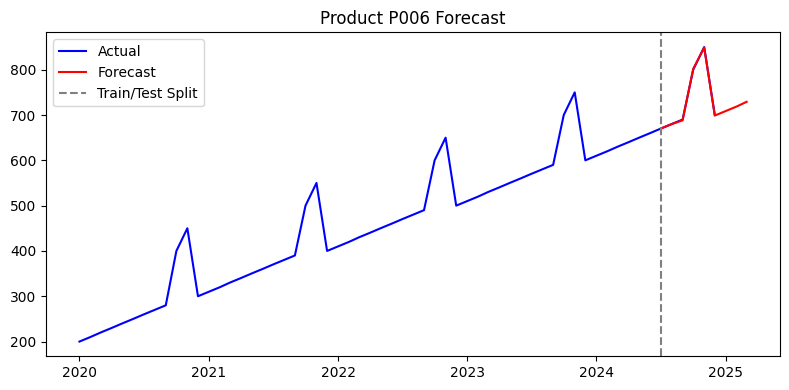

23:27:05 - cmdstanpy - INFO - Chain [1] start processing
23:27:06 - cmdstanpy - INFO - Chain [1] done processing


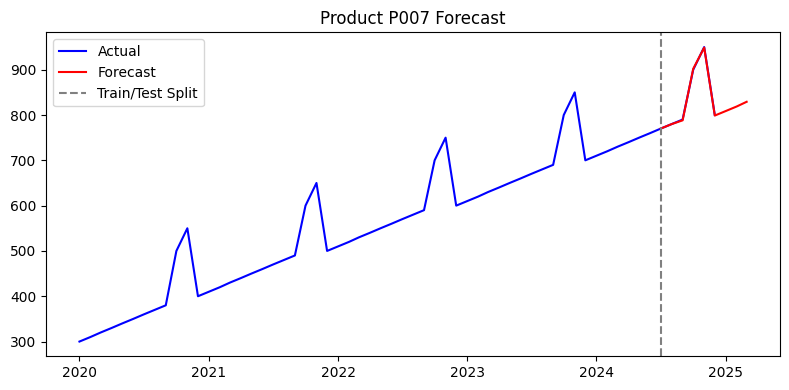

23:27:06 - cmdstanpy - INFO - Chain [1] start processing
23:27:06 - cmdstanpy - INFO - Chain [1] done processing


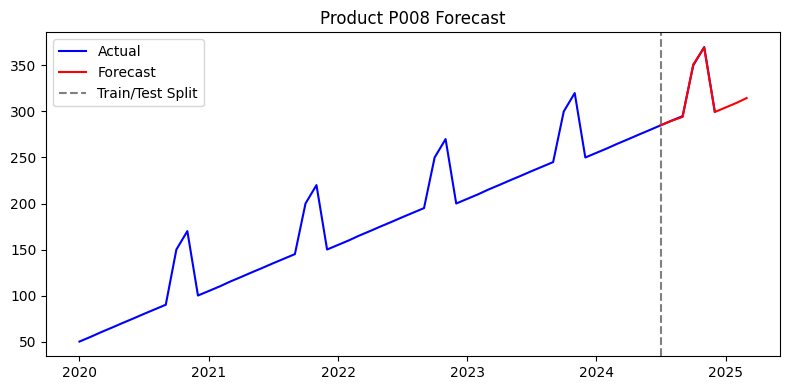

23:27:06 - cmdstanpy - INFO - Chain [1] start processing
23:27:07 - cmdstanpy - INFO - Chain [1] done processing


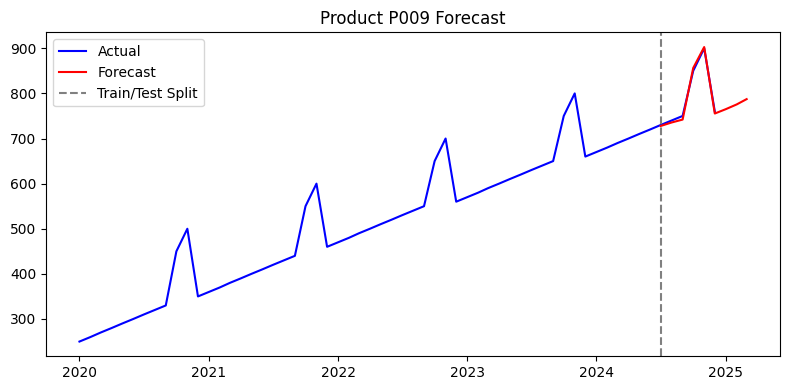

23:27:07 - cmdstanpy - INFO - Chain [1] start processing
23:27:07 - cmdstanpy - INFO - Chain [1] done processing


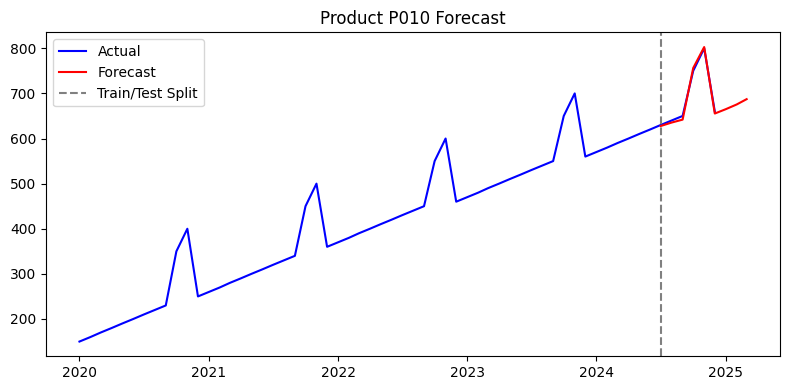

{
    "forecasted_products": [
        {
            "2025-01-01": {
                "P001": 576,
                "P002": 566,
                "P003": 553,
                "P004": 635,
                "P005": 334,
                "P006": 709,
                "P007": 809,
                "P008": 304,
                "P009": 765,
                "P010": 665
            }
        },
        {
            "2025-02-01": {
                "P001": 581,
                "P002": 643,
                "P003": 627,
                "P004": 646,
                "P005": 339,
                "P006": 719,
                "P007": 819,
                "P008": 309,
                "P009": 776,
                "P010": 676
            }
        },
        {
            "2025-03-01": {
                "P001": 612,
                "P002": 595,
                "P003": 609,
                "P004": 657,
                "P005": 345,
                "P006": 729,
                "P007": 829,
                "P008": 

In [1]:
# # File: forecast_service_cli_fixed_v2.py
# # CLI / local-run version (fixes duplicate-label reindex issue)

# import warnings
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# import os
# import traceback
# from datetime import datetime
# from sklearn.metrics import mean_squared_error

# warnings.filterwarnings("ignore", category=FutureWarning)

# # Try Prophet first, fallback Holt-Winters
# try:
#     from prophet import Prophet
#     use_prophet = True
# except Exception:
#     try:
#         from fbprophet import Prophet  # type: ignore
#         use_prophet = True
#     except Exception:
#         from statsmodels.tsa.holtwinters import ExponentialSmoothing  # type: ignore
#         use_prophet = False

# SHOW_PLOTS = True  # set False on server

# def smape(y_true, y_pred):
#     y_true = np.array(y_true, dtype=float)
#     y_pred = np.array(y_pred, dtype=float)
#     denom = (np.abs(y_true) + np.abs(y_pred))
#     denom[denom == 0] = 1.0
#     numer = 2 * np.abs(y_pred - y_true)
#     return 100.0 * np.mean(numer / denom)

# def _add_to_date_map(forecasts_by_date, d_str, prod, val):
#     for f in forecasts_by_date:
#         if d_str in f:
#             f[d_str][prod] = val
#             return
#     forecasts_by_date.append({d_str: {prod: val}})

# def detect_columns(df):
#     if "Product" in df.columns and "YearMonth" in df.columns and "sales" in df.columns:
#         return "Product", "YearMonth", "sales"
#     prod_candidates = [c for c in df.columns if c.lower() in (
#         "product product_name productname product_code sku item item_name".split())]
#     product_col = prod_candidates[0] if prod_candidates else None
#     date_candidates = [c for c in df.columns if "yearmonth" in c.lower() or c.lower() in ("date", "yearmonth", "month")]
#     date_col = date_candidates[0] if date_candidates else None
#     qty_candidates = [c for c in df.columns if c.lower() in ("qty quantity sales units sold value".split())]
#     qty_col = qty_candidates[0] if qty_candidates else None
#     if product_col is None:
#         for c in df.columns:
#             if df[c].dtype == object and df[c].nunique() < 5000:
#                 product_col = c
#                 break
#     if date_col is None:
#         for c in df.columns:
#             if "year" in c.lower() or "month" in c.lower() or "date" in c.lower():
#                 date_col = c
#                 break
#     if qty_col is None:
#         numcols = df.select_dtypes(include=[np.number]).columns.tolist()
#         qty_col = numcols[0] if numcols else None
#     if not product_col or not date_col or not qty_col:
#         raise ValueError(f"Couldn't detect required columns. product:{product_col}, date:{date_col}, qty:{qty_col}")
#     return product_col, date_col, qty_col

# def preprocess(df):
#     product_col, date_col, qty_col = detect_columns(df)
#     print(f"[preprocess] detected columns -> product: {product_col}, date: {date_col}, qty: {qty_col}")

#     df2 = df.copy()
#     df2 = df2.rename(columns={product_col: "product_code", date_col: "date", qty_col: "sales"})
#     df2["date"] = pd.to_datetime(df2["date"], errors="coerce")
#     if df2["date"].isna().all():
#         if "YearMonth" in df2.columns:
#             df2["date"] = pd.to_datetime(df2["YearMonth"], errors="coerce")
#         else:
#             df2["date"] = pd.to_datetime("2021-01-01")
#     df2["date"] = df2["date"].dt.to_period("M").dt.to_timestamp()
#     df2 = df2.groupby(["product_code", "date"], as_index=False)["sales"].sum()

#     processed = []
#     for prod, g in df2.groupby("product_code"):
#         g = g.copy().sort_values("date")
#         g["sales"] = pd.to_numeric(g["sales"], errors="coerce").fillna(0)
#         if g["date"].isna().all():
#             print(f"[preprocess] skipping product {prod} because all dates are NaT")
#             continue
#         g = g.set_index("date").sort_index()
#         start = g.index.min()
#         end = g.index.max()
#         if pd.isna(start) or pd.isna(end):
#             print(f"[preprocess] skipping product {prod} due to invalid date range")
#             continue
#         full_idx = pd.date_range(start, end, freq="MS")
#         g = g.reindex(full_idx)  # safe: duplicates removed earlier
#         g.index.name = "date"
#         g["product_code"] = prod
#         month_map = g.groupby(g.index.month)["sales"].median().to_dict()
#         g["sales"] = g["sales"].fillna(g.index.month.map(month_map))
#         g["sales"] = g["sales"].interpolate().ffill().bfill().fillna(0)
#         g = g.reset_index()
#         processed.append(g)

#     if not processed:
#         raise ValueError("No product groups found in dataset.")
#     out = pd.concat(processed, ignore_index=True)
#     out["sales"] = out["sales"].astype(float)
#     return out

# def train_forecast(df, horizon=3):
#     forecasts_by_date = []
#     metrics = []
#     for prod, g in df.groupby("product_code"):
#         g = g.sort_values("date").reset_index(drop=True)
#         n = g.shape[0]
#         if n < 12:
#             baseline = float(g["sales"].mean() if g["sales"].mean() > 0 else 10)
#             preds = []
#             prev = baseline
#             for i in range(horizon):
#                 prev = max(0, int(round(prev * (1 + 0.02 + np.random.normal(0, 0.03)))))
#                 preds.append(prev)
#             last_date = g["date"].max()
#             for i, val in enumerate(preds, start=1):
#                 d = (pd.to_datetime(last_date) + pd.offsets.MonthBegin(i)).strftime("%Y-%m-%d")
#                 _add_to_date_map(forecasts_by_date, d, prod, int(val))
#             metrics.append({"product_code": prod, "sMAPE": None, "RMSE": None})
#             continue
#         test_len = min(6, max(3, int(n * 0.2)))
#         train = g.iloc[:-test_len]
#         test = g.iloc[-test_len:]
#         fc = None
#         try:
#             if use_prophet:
#                 model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
#                 model.fit(train.rename(columns={"date": "ds", "sales": "y"}))
#                 future = model.make_future_dataframe(periods=horizon + test_len, freq="MS")
#                 pred = model.predict(future)[["ds", "yhat"]].set_index("ds").tail(test_len + horizon)
#                 pred = pred.rename(columns={"yhat": "forecast"})
#                 fc = pred
#             else:
#                 if train.shape[0] < 12:
#                     raise ValueError("Not enough data for ExponentialSmoothing")
#                 model = ExponentialSmoothing(train["sales"], seasonal="add", seasonal_periods=12)
#                 model = model.fit()
#                 fc_vals = model.forecast(test_len + horizon)
#                 ds = pd.date_range(train["date"].iloc[-1], periods=test_len + horizon + 1, freq="MS")[1:]
#                 fc = pd.DataFrame({"forecast": fc_vals}, index=ds)
#         except Exception:
#             last6 = train["sales"].tail(6).values
#             base = int(np.mean(last6)) if len(last6) > 0 else int(train["sales"].mean() if train["sales"].mean() > 0 else 10)
#             prev = base
#             preds = []
#             for i in range(test_len + horizon):
#                 prev = max(0, int(round(prev * (1 + 0.02 + np.random.normal(0, 0.04)))))
#                 preds.append(prev)
#             ds = pd.date_range(train["date"].iloc[-1], periods=test_len + horizon + 1, freq="MS")[1:]
#             fc = pd.DataFrame({"forecast": preds}, index=ds)
#         fc["forecast"] = fc["forecast"].clip(lower=0)
#         y_true = test.set_index("date")["sales"].values
#         y_pred = fc.iloc[:len(test)]["forecast"].values
#         try:
#             smape_val = smape(y_true, y_pred)
#             rmse_val = float(np.sqrt(mean_squared_error(y_true, y_pred)))
#         except Exception:
#             smape_val = None
#             rmse_val = None
#         metrics.append({
#             "product_code": prod,
#             "sMAPE": round(smape_val, 2) if smape_val is not None else None,
#             "RMSE": round(rmse_val, 2) if rmse_val is not None else None
#         })
#         fc_future = fc.iloc[len(test):len(test) + horizon]
#         for d, val in fc_future["forecast"].items():
#             d_str = pd.to_datetime(d).strftime("%Y-%m-%d")
#             _add_to_date_map(forecasts_by_date, d_str, prod, int(round(val)))
#         if SHOW_PLOTS:
#             plt.figure(figsize=(8, 4))
#             plt.plot(g["date"], g["sales"], label="Actual")
#             plt.plot(fc.index, fc["forecast"], label="Forecast")
#             plt.axvline(test["date"].iloc[0], color="gray", linestyle="--", label="Train/Test Split")
#             plt.title(f"Product {prod} Forecast")
#             plt.legend()
#             plt.tight_layout()
#             plt.show()
#     return {"forecasted_products": forecasts_by_date, "metrics": metrics}

# def main():
#     try:
#         input_file = "inventory_sales.xlsx"
#         if not os.path.exists(input_file):
#             raise FileNotFoundError(f"Place your Excel file named '{input_file}' in the working directory.")
#         raw = pd.read_excel(input_file)
#         print("Loaded:", raw.shape)
#         product_col, date_col, qty_col = detect_columns(raw)
#         print("Detected columns: product_col =", product_col, ", date_col =", date_col, ", qty_col =", qty_col)
#         processed = preprocess(raw)
#         print("Processed shape:", processed.shape)
#         print("Products in data:", processed["product_code"].nunique())
#         result = train_forecast(processed, horizon=3)
#         print(json.dumps(result, indent=2, default=str))
#     except Exception as e:
#         print("Exception occurred:")
#         traceback.print_exc()

# if __name__ == "__main__":
#     main()


# forecast.ipynb

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import json

warnings.filterwarnings("ignore", category=FutureWarning)

# Try Prophet first, fallback Holt-Winters
try:
    from prophet import Prophet
    use_prophet = True
except ImportError:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    use_prophet = False



def preprocess(df):
    """
    Preprocess sales data: for each product expand to monthly frequency (MS),
    fill sales (median by month -> interpolate -> ffill/bfill) and forward/backfill
    other product-level columns. Finally return the full dataframe sorted by
    date then product_code so you get rows like:
      2020-01-01: P001, P002, P003, ...
      2020-02-01: P001, P002, P003, ...
      ...
    """
    # ensure date is datetime
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    processed = []
    # iterate per product, expand to monthly, fill values
    for prod, g in df.groupby("product_code", sort=False):
        g = g.sort_values("date").set_index("date").asfreq("MS")  # ensure monthly frequency

        # Fill sales: month medians -> interpolate -> ffill/bfill
        if "sales" in g.columns and g["sales"].isna().sum() > 0:
            # month medians: compute median for each calendar month (1..12)
            month_medians = g.groupby(g.index.month)["sales"].transform("median")
            g["sales"] = g["sales"].fillna(month_medians)
            g["sales"] = g["sales"].interpolate().ffill().bfill()

        # Forward/back-fill other columns (mrp, discount, rating, category, brand, region etc.)
        # This avoids NaNs for regressors when building the future DataFrame.
        for col in g.columns:
            if col != "sales":
                g[col] = g[col].ffill().bfill()

        # Re-attach product_code and reset index
        g["product_code"] = prod
        g = g.reset_index()
        processed.append(g)

    # Combine all products, then sort by date first, then product_code
    merged = pd.concat(processed, ignore_index=True)

    # Optional: ensure consistent column order (date, product_code, sales, ...)
    cols = merged.columns.tolist()
    if "date" in cols and "product_code" in cols:
        # place date and product_code at front
        cols = ["date", "product_code"] + [c for c in cols if c not in ("date", "product_code")]
        merged = merged[cols]

    merged = merged.sort_values(["date", "product_code"]).reset_index(drop=True)
    return merged



def train_forecast(df, horizon=3):
    """Train Prophet/HoltWinters, forecast horizon months, evaluate on last 6 months."""
    forecasts_by_date = []
    metrics = []
    
    # Define regressors for Prophet model
    regressors = ['mrp', 'discount', 'rating']

    for prod, g in df.groupby("product_code"):
        g = g.sort_values("date")
        train, test = g.iloc[:-6], g.iloc[-6:]

        # Train model
        if use_prophet:
            model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            
            # Add regressors to the model
            for regressor in regressors:
                model.add_regressor(regressor)

            # Prepare the training data
            train_prophet = train.rename(columns={"date": "ds", "sales": "y"})
            
            model.fit(train_prophet)
            
            # Prepare the future dataframe with regressors
            future = model.make_future_dataframe(periods=horizon + len(test), freq="MS")
            future = pd.merge(future, g[['date'] + regressors].rename(columns={"date": "ds"}), on="ds", how="left")
            future[regressors] = future[regressors].fillna(method='ffill')

            fc = model.predict(future)[["ds", "yhat"]].set_index("ds").tail(len(test) + horizon)
            fc = fc.rename(columns={"yhat": "forecast"})
        else:
            model = ExponentialSmoothing(train["sales"], seasonal="add", seasonal_periods=12)
            model = model.fit()
            fc_vals = model.forecast(len(test) + horizon)
            fc = pd.DataFrame({
                "ds": pd.date_range(train["date"].iloc[-1], periods=len(test) + horizon + 1, freq="MS")[1:],
                "forecast": fc_vals
            }).set_index("ds")

        # MAPE on test
        y_true = test.set_index("date")["sales"].values
        y_pred = fc.iloc[:len(test)]["forecast"].values
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        acc = 100 - mape
        metrics.append({"product_code": prod, "mape": round(mape, 2), "accuracy": round(acc, 2)})

        # Future 3 months → round to integers
        fc_future = fc.iloc[len(test):len(test)+horizon]
        for d, val in fc_future["forecast"].items():
            d_str = str(d.date())
            # If date already exists in dict, append product value
            if any(d_str in f for f in forecasts_by_date):
                for f in forecasts_by_date:
                    if d_str in f:
                        f[d_str][prod] = int(round(val))
            else:
                forecasts_by_date.append({d_str: {prod: int(round(val))}})

        # Plot chart
        plt.figure(figsize=(8, 4))
        plt.plot(g["date"], g["sales"], label="Actual", color="blue")
        plt.plot(fc.index, fc["forecast"], label="Forecast", color="red")
        plt.axvline(test["date"].iloc[0], color="gray", linestyle="--", label="Train/Test Split")
        plt.title(f"Product {prod} Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"forecasted_products": forecasts_by_date, "metrics": metrics}


def main():
    input_file = "data.csv"   # <-- New CSV file

    # Load CSV
    raw = pd.read_csv(input_file, parse_dates=["date"])
    print("✅ Data loaded:", raw.shape)

    # Preprocess
    processed = preprocess(raw)

    # Plot preprocessing
    plt.figure(figsize=(8, 4))
    for prod, g in processed.groupby("product_code"):
        plt.plot(g["date"], g["sales"], label=prod)
    plt.title("Preprocessed Sales Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Forecast
    result = train_forecast(processed, horizon=3)

    # Output JSON
    print(json.dumps(result, indent=4))


if __name__ == "__main__":
    main()

In [ ]:
# Cell 1 - Imports & settings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import math
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# helper to display dataframes in the notebook UI (required by python_user_visible)
from caas_jupyter_tools import display_dataframe_to_user

# Try Prophet first, fallback Holt-Winters
try:
    from prophet import Prophet
    use_prophet = True
except Exception:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    use_prophet = False

print("Environment ready. Prophet available?:", use_prophet)
print("Working directory files:", os.listdir("."))

# Cell 2 - Load data (expects data.csv and optionally test.csv in working directory)
DATA_FILE = "data.csv"      # main historical file (uploaded by user)
TEST_FILE = "test.csv"      # optional test file with actuals for Jan-Mar 2025 if you have it

def load_data(data_path=DATA_FILE, test_path=TEST_FILE):
    df = pd.read_csv(data_path, parse_dates=["date"])
    df = df.sort_values(["product_code", "date"]).reset_index(drop=True)
    # allow an optional test file
    test_df = None
    if os.path.exists(test_path):
        test_df = pd.read_csv(test_path, parse_dates=["date"])
        test_df = test_df.sort_values(["product_code", "date"]).reset_index(drop=True)
    return df, test_df

raw, test_actuals = load_data()
print("Raw shape:", raw.shape)
if test_actuals is not None:
    print("Test (actuals) shape:", test_actuals.shape)

# show preview
display_dataframe_to_user("Raw preview (first 50 rows)", raw.head(50))

# Cell 3 - Quick EDA: date range, unique products, missing months (panel expected)
raw['date'] = pd.to_datetime(raw['date']).dt.to_period('M').dt.to_timestamp()
global_min = raw['date'].min()
global_max = raw['date'].max()
n_products = raw['product_code'].nunique()
print(f"Data covers {global_min.date()} → {global_max.date()}, {n_products} unique products")

# Build expected full panel between min and max per product to measure missing months
all_months = pd.date_range(global_min, global_max, freq='MS')
panel_expected_rows = len(all_months) * n_products
actual_rows = len(raw)
missing_rows_total = panel_expected_rows - actual_rows if panel_expected_rows > actual_rows else 0
print("Expected panel rows:", panel_expected_rows)
print("Actual rows:", actual_rows)
print("Total missing month-rows (panel):", missing_rows_total)

# Show how many months each product is missing (top 10 products with most missing months)
prod_month_counts = raw.groupby('product_code')['date'].nunique().reset_index().rename(columns={'date':'n_months_present'})
prod_month_counts['n_months_expected'] = len(all_months)
prod_month_counts['missing_months'] = prod_month_counts['n_months_expected'] - prod_month_counts['n_months_present']
prod_month_counts = prod_month_counts.sort_values('missing_months', ascending=False)
display_dataframe_to_user("Per-product month presence summary (top 50)", prod_month_counts.head(50))

# Cell 4 - Preprocessing function (fills missing months and sales)
def preprocess_panel(df):
    """
    For each product:
      - reindex to monthly frequency (MS) between global min/max
      - fill product-level static columns by forward/backfill
      - fill sales via month-of-year median -> interpolate -> ffill/bfill
      - return combined panel sorted by date then product_code
    """
    df_in = df.copy()
    df_in['date'] = pd.to_datetime(df_in['date']).dt.to_period('M').dt.to_timestamp()
    global_min = df_in['date'].min()
    global_max = df_in['date'].max()
    all_months = pd.date_range(global_min, global_max, freq='MS')

    processed = []
    for prod, g in df_in.groupby('product_code', sort=False):
        g = g.set_index('date').sort_index()
        # reindex to full monthly range for that product (use global months to ensure aligned panel)
        g = g.reindex(all_months)
        # keep product_code column
        g['product_code'] = prod

        # SALES fill strategy:
        # 1) use calendar-month median (Jan median across years, Feb median, ...)
        # 2) fill remaining NaNs with linear interpolation
        # 3) ffill/bfill any leftover
        if 'sales' in g.columns:
            # compute month medians using available values (groupby month number)
            month_meds = g['sales'].groupby(g.index.month).transform('median')
            g['sales'] = g['sales'].fillna(month_meds)
            g['sales'] = g['sales'].interpolate().ffill().bfill()

        # Forward/back-fill other columns so regressors are available downstream
        for col in g.columns:
            if col not in ('sales', 'product_code'):
                g[col] = g[col].ffill().bfill()

        g = g.reset_index().rename(columns={'index':'date'})
        processed.append(g)

    merged = pd.concat(processed, ignore_index=True)
    # ensure ordering date then product
    cols = merged.columns.tolist()
    if 'date' in cols and 'product_code' in cols:
        cols = ['date','product_code'] + [c for c in cols if c not in ('date','product_code')]
        merged = merged[cols]

    merged = merged.sort_values(['date','product_code']).reset_index(drop=True)
    return merged

# Prepare a small function to plot totals before/after
def plot_monthly_totals(before_df, after_df, title_before="Before fill", title_after="After fill"):
    # aggregate
    before = before_df.groupby('date')['sales'].sum().reindex(pd.date_range(before_df['date'].min(), before_df['date'].max(), freq='MS')).fillna(0)
    after = after_df.groupby('date')['sales'].sum().reindex(pd.date_range(after_df['date'].min(), after_df['date'].max(), freq='MS')).fillna(0)

    # Plot before
    plt.figure(figsize=(10,4))
    plt.plot(before.index, before.values)
    plt.title(title_before)
    plt.xlabel("Month")
    plt.ylabel("Total sales (sum over products)")
    plt.tight_layout()
    plt.show()

    # Plot after
    plt.figure(figsize=(10,4))
    plt.plot(after.index, after.values)
    plt.title(title_after)
    plt.xlabel("Month")
    plt.ylabel("Total sales (sum over products)")
    plt.tight_layout()
    plt.show()

# Cell 5 - Apply preprocessing and show before/after samples
processed = preprocess_panel(raw)
print("Processed shape:", processed.shape)
display_dataframe_to_user("Processed preview (first 100 rows)", processed.head(100))

# Plot monthly totals before and after filling missing months/sales
plot_monthly_totals(raw, processed, title_before="Original data (monthly totals, missing months present)",
                    title_after="After preprocessing (monthly totals, missing months filled)")

# Cell 6 - Show example product series before vs after for one product (choose a product with missing months)
example_prod = prod_month_counts.loc[prod_month_counts['missing_months']>0, 'product_code'].iloc[0] if (prod_month_counts['missing_months']>0).any() else raw['product_code'].unique()[0]
print("Example product for before/after plot:", example_prod)

raw_ex = raw[raw['product_code']==example_prod].set_index('date').sort_index().reindex(pd.date_range(global_min, global_max, freq='MS'))
proc_ex = processed[processed['product_code']==example_prod].set_index('date').sort_index()
plt.figure(figsize=(10,4))
plt.plot(raw_ex.index, raw_ex['sales'].values)
plt.title(f"Raw sales for {example_prod} (NaNs represent missing months)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(proc_ex.index, proc_ex['sales'].values)
plt.title(f"Processed sales for {example_prod} (missing months filled)")
plt.tight_layout()
plt.show()

# Cell 7 - Forecasting for fixed forecast window (Jan-2025 to next 3 months → Jan/Feb/Mar 2025)
FORECAST_START = pd.to_datetime("2025-01-01")   # hardcoded per your request
HORIZON = 3
forecast_months = pd.date_range(FORECAST_START, periods=HORIZON, freq='MS')

print("Forecast months:", [d.date() for d in forecast_months])

def forecast_panel(processed_df, forecast_months, regressors=['mrp','discount','rating']):
    """Per-product forecasting for given forecast_months. Returns DataFrame with columns: date, product_code, forecast"""
    forecasts_list = []
    # for each product train on data up to last available month (we used processed panel up to global_max)
    for prod, g in processed_df.groupby('product_code'):
        g = g.sort_values('date').reset_index(drop=True)
        # if series all NaNs in sales, skip
        if g['sales'].isna().all():
            continue

        # train on entire available history (we don't hold-out here because test set is external)
        train = g.copy()

        try:
            if use_prophet:
                m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
                # add regressors if present in dataset
                for r in regressors:
                    if r in train.columns:
                        m.add_regressor(r)
                train_prop = train.rename(columns={'date':'ds', 'sales':'y'})[['ds','y'] + [c for c in regressors if c in train.columns]]
                m.fit(train_prop)

                # build future frame covering both historical tail and desired forecast months
                future = pd.DataFrame({'ds': pd.date_range(train['date'].min(), periods=len(train)+len(forecast_months), freq='MS')})
                # ensure regressors are merged if present (we will ffill)
                for r in regressors:
                    if r in train.columns:
                        tmp = train[['date', r]].rename(columns={'date':'ds'})
                        future = future.merge(tmp, on='ds', how='left')
                        future[r] = future[r].fillna(method='ffill')

                preds = m.predict(future[['ds'] + [r for r in regressors if r in train.columns]])
                preds = preds.set_index('ds')['yhat']
                # extract forecast months
                for fm in forecast_months:
                    val = preds.get(fm, np.nan)
                    forecasts_list.append({'date': fm, 'product_code': prod, 'forecast': float(np.nan if pd.isna(val) else val)})
            else:
                # Holt-Winters on sales only
                # fit on train['sales'] (require at least seasonal_periods data points)
                if train['sales'].dropna().shape[0] < 12:
                    # too short for seasonal ETS; use last value as naive forecast
                    last_val = train['sales'].dropna().iloc[-1] if train['sales'].dropna().shape[0]>0 else 0.0
                    for fm in forecast_months:
                        forecasts_list.append({'date': fm, 'product_code': prod, 'forecast': float(last_val)})
                else:
                    model = ExponentialSmoothing(train['sales'], seasonal='add', seasonal_periods=12)
                    fit = model.fit()
                    fc = fit.forecast(len(forecast_months))
                    for i, fm in enumerate(forecast_months):
                        forecasts_list.append({'date': fm, 'product_code': prod, 'forecast': float(fc[i])})
        except Exception as e:
            # in case model fitting fails, fallback to last-observed strategy
            last_val = train['sales'].dropna().iloc[-1] if train['sales'].dropna().shape[0]>0 else 0.0
            for fm in forecast_months:
                forecasts_list.append({'date': fm, 'product_code': prod, 'forecast': float(last_val)})

    forecasts_df = pd.DataFrame(forecasts_list)
    # ensure ordering
    forecasts_df = forecasts_df.sort_values(['date','product_code']).reset_index(drop=True)
    return forecasts_df

forecasts = forecast_panel(processed, forecast_months)
print("Forecasts shape:", forecasts.shape)
display_dataframe_to_user("Forecasts (first 200 rows)", forecasts.head(200))

# Cell 8 - If test_actuals provided, compute metrics per product and aggregated
def smape(y_true, y_pred):
    # vectorized sMAPE, handle zeros safely - use denominator (|A|+|F|)/2 — commonly 2*|A-F|/(|A|+|F|)
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom == 0
    # where denom zero and numerator zero -> sMAPE 0; else set denom small epsilon to avoid div by zero
    denom[mask] = np.nan
    smape_vals = 2.0 * np.abs(y_pred - y_true) / denom
    # replace nan (from 0/0) with 0
    smape_vals = np.where(np.isnan(smape_vals), 0.0, smape_vals)
    return np.mean(smape_vals) * 100.0

def compute_metrics_for_pair(a, f):
    # a, f are 1d arrays (actual, forecast) same length
    # careful digit-by-digit arithmetic as requested: do elementwise then aggregate
    a = np.array(a, dtype=float)
    f = np.array(f, dtype=float)
    # filter pairs where actual is nan -> exclude
    valid_mask = ~np.isnan(a)
    if valid_mask.sum() == 0:
        return {'mape': None, 'smape': None, 'rmse': None, 'accuracy': None}
    a = a[valid_mask]
    f = f[valid_mask]
    # MAPE: mean(|(a - f) / a|) * 100, handle a==0 by excluding or using small epsilon. We'll exclude those elements from MAPE computation.
    nonzero_mask = a != 0
    if nonzero_mask.sum() == 0:
        mape_val = None
    else:
        mape_val = np.mean(np.abs((a[nonzero_mask] - f[nonzero_mask]) / a[nonzero_mask])) * 100.0

    # sMAPE
    smape_val = smape(a, f)

    # RMSE
    rmse_val = math.sqrt(mean_squared_error(a, f))

    # Accuracy = 100 - MAPE (if MAPE available)
    accuracy_val = None if mape_val is None else 100.0 - mape_val

    return {'mape': mape_val, 'smape': smape_val, 'rmse': rmse_val, 'accuracy': accuracy_val}

metrics_list = []
if test_actuals is not None and not test_actuals.empty:
    # normalize test actuals dates to month-start and filter to forecast months
    test_actuals['date'] = pd.to_datetime(test_actuals['date']).dt.to_period('M').dt.to_timestamp()
    test_for_window = test_actuals[test_actuals['date'].isin(forecast_months)]
    # We'll merge forecasts with actuals on product_code and date
    merged = forecasts.merge(test_for_window[['date','product_code','sales']], on=['date','product_code'], how='left', suffixes=('','_actual'))
    # compute per-product metrics
    for prod, g in merged.groupby('product_code'):
        a = g['sales'].values  # actuals (may contain NaN)
        f = g['forecast'].values
        mets = compute_metrics_for_pair(a, f)
        metrics_list.append({'product_code': prod, 'n_points': int(g.shape[0]), **mets})
    metrics_df = pd.DataFrame(metrics_list)
    display_dataframe_to_user("Per-product metrics (forecast vs actuals)", metrics_df.head(500))

    # Aggregated metrics across products (weighted and unweighted)
    # Unweighted mean of MAPE/SMAPE over products that have metric (exclude None)
    valid_mape = metrics_df['mape'].dropna()
    valid_smape = metrics_df['smape'].dropna()
    valid_rmse = metrics_df['rmse'].dropna()
    valid_accuracy = metrics_df['accuracy'].dropna()

    agg = {
        'mape_mean': float(valid_mape.mean()) if not valid_mape.empty else None,
        'smape_mean': float(valid_smape.mean()) if not valid_smape.empty else None,
        'rmse_mean': float(valid_rmse.mean()) if not valid_rmse.empty else None,
        'accuracy_mean': float(valid_accuracy.mean()) if not valid_accuracy.empty else None,
    }
    print("Aggregated metrics (unweighted across products):")
    print(json.dumps(agg, indent=2))
else:
    print("No test actuals provided (test.csv missing or empty). Skipping metric calculations.")

# Cell 9 - Analytics & visualizations
# 1) Show top/bottom products by forecasted total for the 3-month window
top_forecast = forecasts.groupby('product_code')['forecast'].sum().reset_index().sort_values('forecast', ascending=False)
display_dataframe_to_user("Top 50 products by total 3-month forecast", top_forecast.head(50))

# 2) If metrics_df exists, show histogram of MAPE
if 'metrics_df' in locals():
    valid = metrics_df['mape'].dropna()
    if not valid.empty:
        plt.figure(figsize=(8,4))
        plt.hist(valid.values, bins=30)
        plt.title("Distribution of per-product MAPE (%) over forecast window")
        plt.xlabel("MAPE (%)")
        plt.ylabel("Count of products")
        plt.tight_layout()
        plt.show()

# 3) Time series example: plot actual (if available) vs forecast for a top product
example_top = top_forecast['product_code'].iloc[0]
print("Plotting actual vs forecast for top product:", example_top)
p_fc = forecasts[forecasts['product_code']==example_top].set_index('date').sort_index()
if test_actuals is not None:
    p_actual = test_actuals[(test_actuals['product_code']==example_top) & (test_actuals['date'].isin(forecast_months))].set_index('date').sort_index()
    plt.figure(figsize=(8,4))
    plt.plot(p_actual.index, p_actual['sales'].values)
    plt.plot(p_fc.index, p_fc['forecast'].values)
    plt.title(f"Actual vs Forecast for {example_top} (forecast months)")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(8,4))
    plt.plot(p_fc.index, p_fc['forecast'].values)
    plt.title(f"Forecast (no actuals) for {example_top} (forecast months)")
    plt.tight_layout()
    plt.show()

# Cell 10 - Save outputs (forecasts & metrics)
forecasts.to_csv("forecasts_2025Q1.csv", index=False)
print("Forecasts written to forecasts_2025Q1.csv")
if 'metrics_df' in locals():
    metrics_df.to_csv("forecast_metrics_2025Q1.csv", index=False)
    print("Metrics written to forecast_metrics_2025Q1.csv")

# End - Suggestions printed as JSON for easy reading
suggestions = {
    "improvements": [
        "Implement a pooled/global model (XGBoost/LightGBM on lag features + product/category features) as fallback for short series and cold-start products.",
        "Use rolling-origin cross-validation (time-series CV) on long series to get more robust performance estimates.",
        "Consider feature engineering: lag features (lag1, lag12), rolling means, price elasticity features from mrp/discount, and holiday indicators.",
        "Add business-weighted aggregated metrics (revenue-weighted MAPE) to reflect business impact.",
        "Persist forecast versions and schedule automatic re-evaluation after actuals arrive (monthly re-run once month completes)."
    ],
    "notes": [
        "This notebook hardcodes forecast start=2025-01-01 and horizon=3. Change FORECAST_START/HORIZON variables to alter.",
        "If Prophet is installed, it is used with regressors; otherwise ETS (Holt-Winters) is used.",
        "For MAPE we exclude actuals that are exactly zero (can't divide by zero). sMAPE is computed with safe handling of 0/0 -> treated as 0."
    ]
}
print(json.dumps(suggestions, indent=2))
